In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
from pokerl.env.pokemonblue import PokemonBlueEnv

x = torch.rand( 1, 160, 144)

In [3]:
x = torchvision.transforms.Resize((128, 128)).forward(x.unsqueeze(0)).squeeze(0)

/home/bpugnaire/dev/pokeRL/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
x = torch.rand(160, 144)
x=x.float() 
x = x.unsqueeze(0)  # Add a channel dimension

normalizer = torchvision.transforms.Normalize(mean=[0], std=[1])
x = normalizer.forward(x)

In [5]:
x.shape

torch.Size([1, 160, 144])

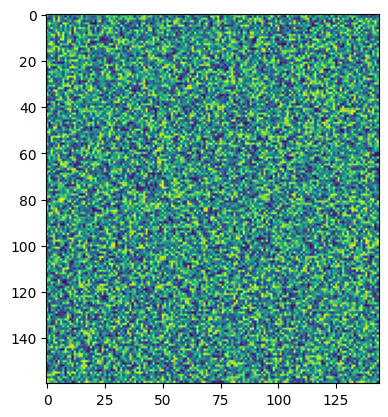

In [6]:
plt.imshow(x.permute(1, 2, 0)  )


In [7]:
grey_scaler= torchvision.transforms.Grayscale()
x  = grey_scaler.forward(x)
x = torchvision.transforms.Resize((160, 144)).forward(x)

In [8]:
x.shape

torch.Size([1, 160, 144])

In [9]:
from pokerl.agent.own_dreamer.nets.image_encoder_decoder import ImageEncoderResnet
ImageEncoderResnet()


ImageEncoderResnet(
  (_net): Sequential(
    (0): Conv2d(3, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ResidualBlock(
      (_act1): SiLU()
      (_act2): SiLU()
      (_conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ResidualBlock(
      (_act1): SiLU()
      (_act2): SiLU()
      (_conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_conv2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (3): Conv2d(48, 96, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): ResidualBlock(
      (_act1): SiLU()
      (_act2): SiLU()
      (_conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (5): ResidualBlock(
      (_act1): SiLU()
      (_act2): SiLU()
      (_conv1): Conv2d(96, 

In [10]:
z = ImageEncoderResnet(input_shape=x.shape).forward(x)


torch.Size([48, 80, 72])
torch.Size([48, 80, 72])
torch.Size([48, 80, 72])
torch.Size([48, 80, 72])
torch.Size([96, 40, 36])
torch.Size([96, 40, 36])
torch.Size([96, 40, 36])
torch.Size([96, 40, 36])
torch.Size([192, 20, 18])
torch.Size([192, 20, 18])
torch.Size([192, 20, 18])
torch.Size([192, 20, 18])
torch.Size([384, 10, 9])
torch.Size([384, 10, 9])
torch.Size([384, 10, 9])
torch.Size([384, 10, 9])
torch.Size([768, 5, 4])
torch.Size([768, 5, 4])
torch.Size([768, 5, 4])
torch.Size([768, 5, 4])


In [11]:
from pokerl.agent.own_dreamer.nets.image_encoder_decoder import ImageDecoderResnet
ImageDecoderResnet(feature_length=len(z), output_shape=x.shape)

ImageDecoderResnet(
  (_lin): Linear(in_features=768, out_features=12288, bias=True)
  (_net): Sequential(
    (0): ResidualBlock(
      (_act1): SiLU()
      (_act2): SiLU()
      (_conv1): ConvTranspose2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_conv2): ConvTranspose2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): ResidualBlock(
      (_act1): SiLU()
      (_act2): SiLU()
      (_conv1): ConvTranspose2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_conv2): ConvTranspose2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (2): ConvTranspose2d(384, 192, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ResidualBlock(
      (_act1): SiLU()
      (_act2): SiLU()
      (_conv1): ConvTranspose2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (_conv2): ConvTranspose2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (4): ResidualBlock(
      (_act1): 

In [13]:

z = z.flatten()
ImageDecoderResnet(feature_length=len(z), output_shape=x.shape).forward(z)

torch.Size([768, 4, 4])
torch.Size([768, 4, 4])
torch.Size([768, 4, 4])
torch.Size([768, 4, 4])


RuntimeError: Given transposed=1, weight of size [384, 192, 4, 4], expected input[1, 768, 4, 4] to have 384 channels, but got 768 channels instead

In [19]:
len(z)

15360

In [10]:
from pokerl.agent.own_dreamer.nets.reference import ConvEncoder

encoder = ConvEncoder((128,128,1), depth=48)

ModuleNotFoundError: No module named 'pokerl.agent.own_dreamer.nets.reference'

In [ ]:
encoder.forward(x.reshape((1, 128, 128, 1))).shape

torch.Size([1, 48, 64, 64])
torch.Size([1, 96, 32, 32])
torch.Size([1, 192, 16, 16])
torch.Size([1, 384, 8, 8])
torch.Size([1, 768, 4, 4])


torch.Size([1, 12288])

In [ ]:
input_size = 129
kernel_size = 4
stride = 2
padding = 0
print((input_size - kernel_size + 2*padding) / stride + 1)

63.5
